In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot, select_ACC, select_Equator
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted, CoarsenKochkovMinMax
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

import matplotlib as mpl

%load_ext autoreload
%autoreload 3

In [20]:
def read_skill(exp='EXP0', factors=[4,9,12,15]):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = -data['zl']
        ds[factor] = data
        
    return ds

In [44]:
exp = read_skill('EXP1')

In [129]:
def backscatter_ratio(transfer, freq_str):
    transfer_noncompensated = transfer / transfer[freq_str]
    transfer_plus = np.maximum(transfer_noncompensated,0.0)
    transfer_minus =  np.minimum(transfer_noncompensated,0.0)
    return -transfer_plus.sum(freq_str) / transfer_minus.sum(freq_str)

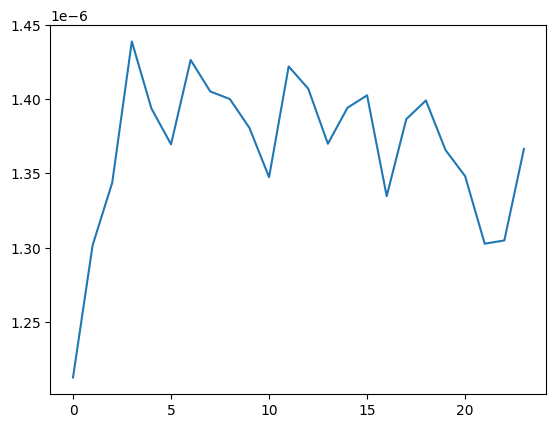

In [65]:
plt.plot(np.diff(exp[12].transfer_Equator.freq_r_Equator))

Text(0.5, 1.0, 'Equator')

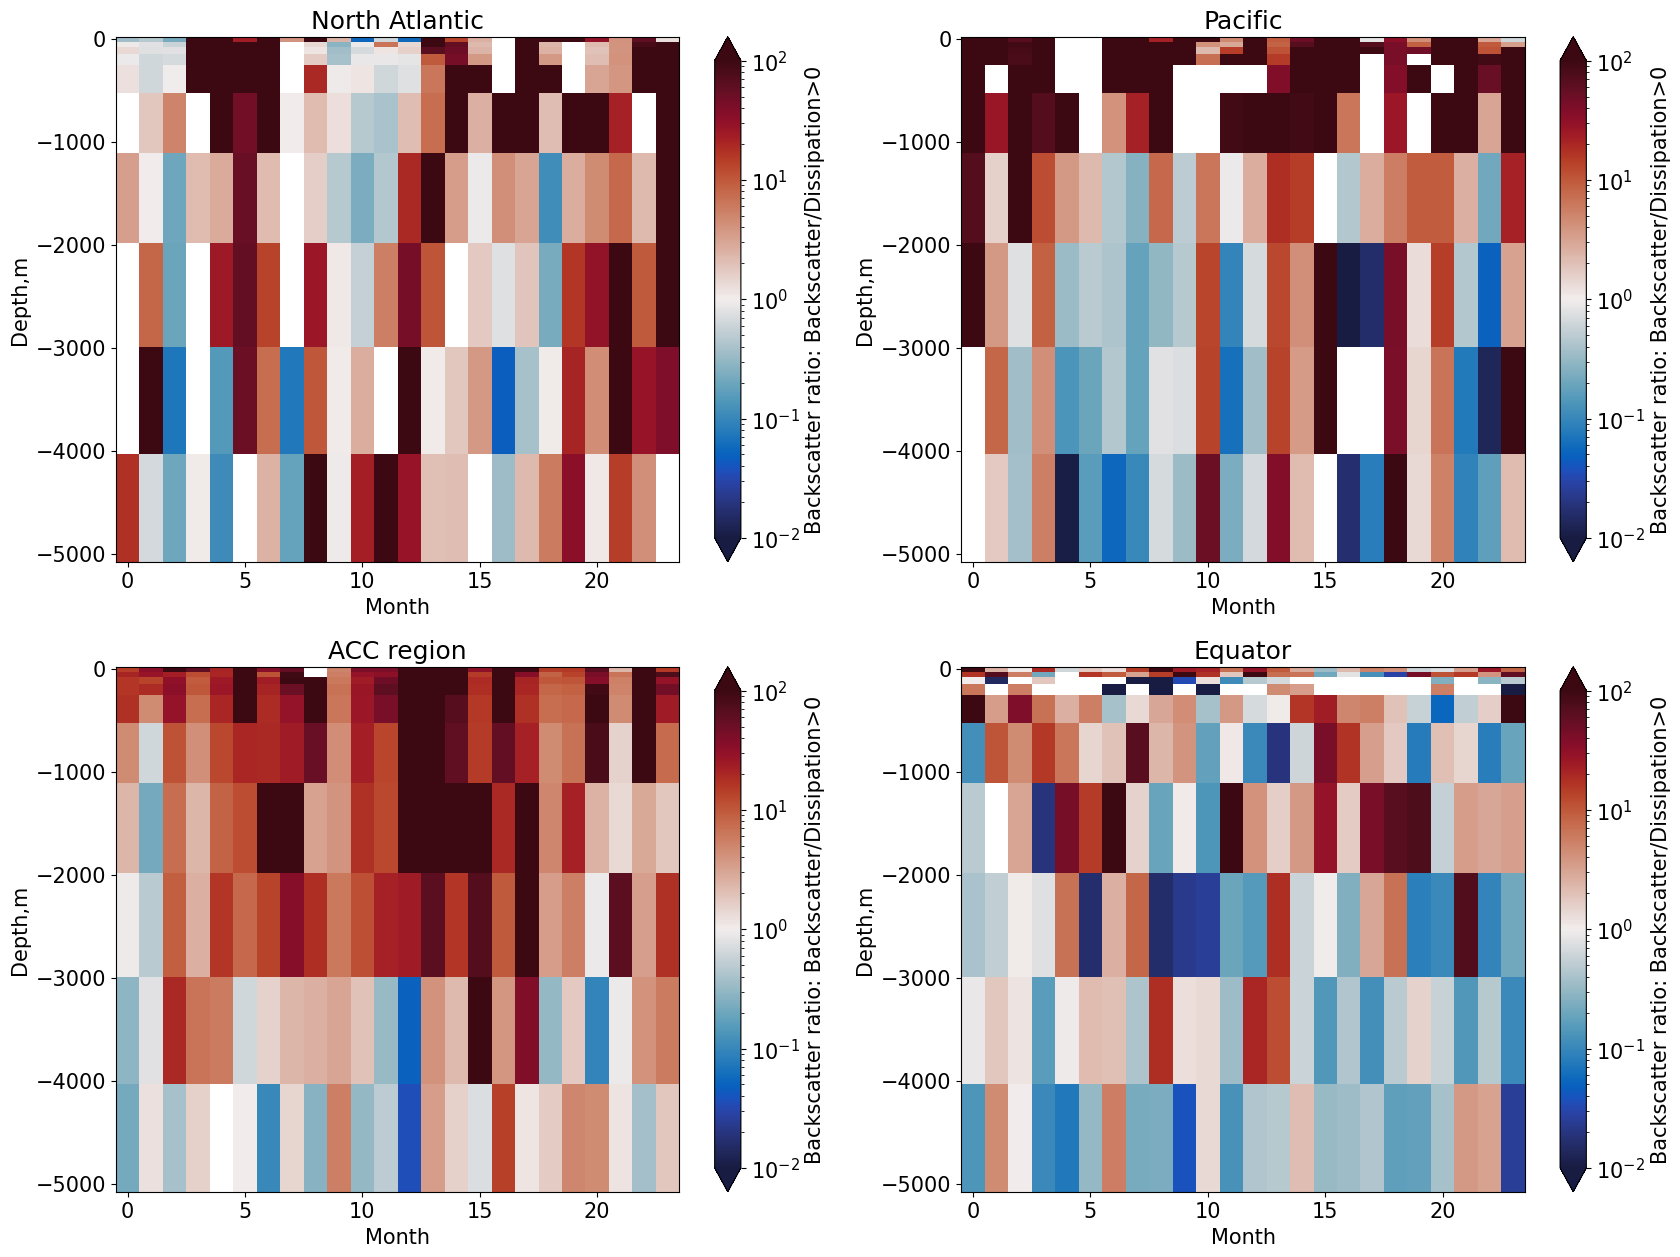

In [135]:
plt.figure(figsize=(20,15))
plt.rcParams['font.size']=15
kw = dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1e+2), 
          cmap=cmocean.cm.balance, 
          cbar_kwargs={'label': 'Backscatter ratio: Backscatter/Dissipation>0'},
          y='zl')
factor = 15
plt.subplot(2,2,1)
backscatter_ratio(exp[factor].transfer_NA, 'freq_r_NA').drop_vars('time').plot(**kw)
plt.xlabel('Month')
plt.ylabel('Depth,m')
plt.title('North Atlantic')

plt.subplot(2,2,2)
backscatter_ratio(exp[factor].transfer_Pacific, 'freq_r_Pacific').drop_vars('time').plot(**kw)
plt.xlabel('Month')
plt.ylabel('Depth,m')
plt.title('Pacific')

plt.subplot(2,2,3)
backscatter_ratio(exp[factor].transfer_ACC, 'freq_r_ACC').drop_vars('time').plot(**kw)
plt.xlabel('Month')
plt.ylabel('Depth,m')
plt.title('ACC region')

plt.subplot(2,2,4)
backscatter_ratio(exp[factor].transfer_Equator, 'freq_r_Equator').drop_vars('time').plot(**kw)
plt.xlabel('Month')
plt.ylabel('Depth,m')
plt.title('Equator')

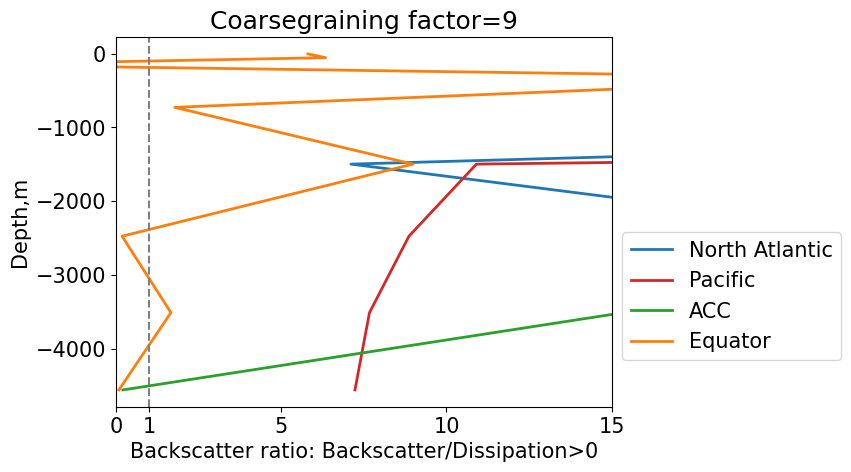

In [170]:
for factor, ls in zip([9], ['-', '--', '-.', ':']):
    backscatter_ratio(exp[factor].transfer_NA.mean('time'), 'freq_r_NA').plot(y='zl', ls=ls, color='tab:blue', lw=2, label='North Atlantic')
    backscatter_ratio(exp[factor].transfer_Pacific.mean('time'), 'freq_r_Pacific').plot(y='zl', ls=ls, color='tab:red', lw=2, label='Pacific')
    backscatter_ratio(exp[factor].transfer_ACC.mean('time'), 'freq_r_ACC').plot(y='zl', ls=ls, color='tab:green', lw=2, label='ACC')
    backscatter_ratio(exp[factor].transfer_Equator.mean('time'), 'freq_r_Equator').plot(y='zl', ls=ls, color='tab:orange', lw=2, label='Equator')
plt.xlabel('Backscatter ratio: Backscatter/Dissipation>0')
plt.ylabel('Depth,m')
plt.axvline(x=1, color='gray', ls='--')
plt.xlim([0,15])
plt.title('')
plt.legend(bbox_to_anchor=(1,0.5))
plt.xticks([0,1,5,10,15])
plt.title('Coarsegraining factor=9')
plt.savefig('data-garbage/factor-9.pdf', bbox_inches='tight')

In [171]:
ds = read_datasets(['test'], [4,9])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4
Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-9


In [172]:
skill_ZB_9 = ds['test-9'].predict_ANN(None,None,None).SGS_skill()

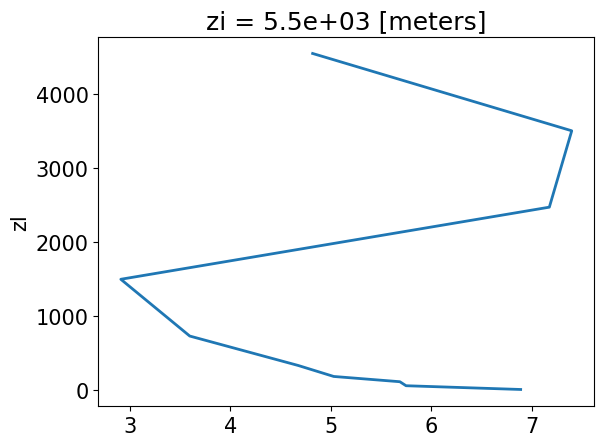

In [175]:
 backscatter_ratio(skill_ZB_9.transfer_ZB_NA.mean('time'), 'freq_r_NA').plot(y='zl', ls=ls, color='tab:blue', lw=2, label='North Atlantic')

Text(0.5, 0, 'Wavenumber, m$^{-1}$')

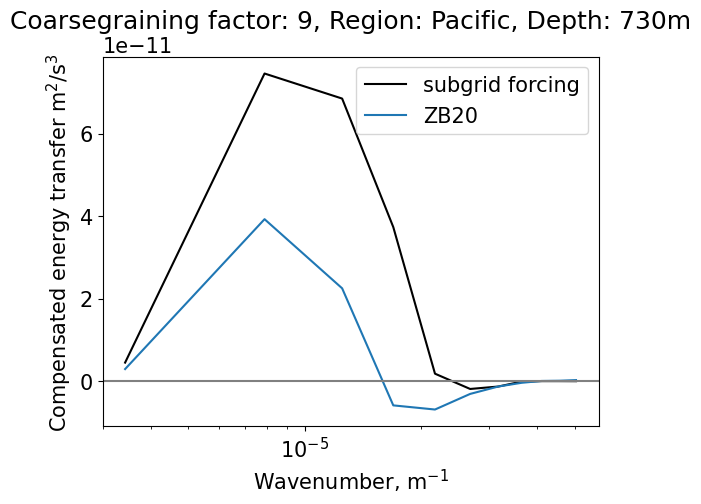

In [237]:
skill_ZB_9.transfer_Pacific.mean('time').isel(zl=5).plot(xscale='log', color='k', label='subgrid forcing')
skill_ZB_9.transfer_ZB_Pacific.mean('time').isel(zl=5).plot(xscale='log', label='ZB20')
plt.legend()
plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
plt.title('Coarsegraining factor: 9, Region: Pacific, Depth: 730m')
plt.axhline(y=0,color='gray')
plt.xlabel('Wavenumber, m$^{-1}$')

Text(0.5, 0, 'Wavenumber, m$^{-1}$')

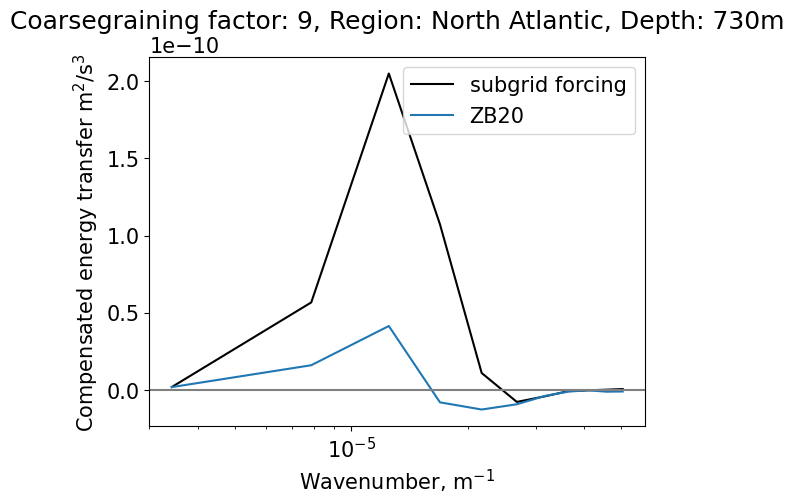

In [238]:
skill_ZB_9.transfer_NA.mean('time').isel(zl=5).plot(xscale='log', color='k', label='subgrid forcing')
skill_ZB_9.transfer_ZB_NA.mean('time').isel(zl=5).plot(xscale='log', label='ZB20')
plt.legend()
plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
plt.title('Coarsegraining factor: 9, Region: North Atlantic, Depth: 730m')
plt.axhline(y=0,color='gray')
plt.xlabel('Wavenumber, m$^{-1}$')

In [395]:
def plot_transfer(transfer, freq_str='freq_r_NA', zl=0, color='tab:blue'):
    mean = transfer.mean('time').isel(zl=zl)
    std = transfer.std('time').isel(zl=zl)
    
    mean.plot(xscale='log',color=color)
    plt.fill_between(mean[freq_str],mean-std,mean+std,alpha=0.2,color=color, linewidth=0)
    return backscatter_ratio(mean,freq_str)

# Transfer spectrum and deformation radius

In [353]:
ds = read_datasets(['validate'], [4])

Reading from folder /scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-4


In [365]:
def select(x, region):
    if region == 'NA':
        kw = {'Lat': (25,45), 'Lon': (-60,-40)}
    elif region == 'Pacific':
        kw = {'Lat': (25,45), 'Lon': (-200,-180)}
    elif region == 'Equator':
        kw = {'Lat': (-30,30), 'Lon': (-190,-130)}
    elif region == 'ACC':
        kw = {'Lat': (-70,-30), 'Lon': (-40,0)}
    else:
        print('Error: wrong region')
    return select_LatLon(x,time=slice(None,None),**kw)

In [366]:
Ld = ds['validate-4'].data.deformation_radius/1e+3

In [374]:
for region in ['NA', 'Pacific', 'ACC', 'Equator']:
    print(region, float(select(Ld, region).mean()))

NA 22.61805534362793
Pacific 28.477930068969727
ACC 10.45057487487793
Equator 88.92626190185547


In [420]:
def plot_transfer_4_regions(zl=5,factor=4):
    plt.figure(figsize=(10,8))
    plt.rcParams['font.size']=12
    plt.subplot(2,2,1)
    ratio = plot_transfer(exp[factor].transfer_NA,'freq_r_NA',color='k',zl=zl)
    plot_transfer(exp[factor].transfer_ZB_NA,'freq_r_NA',zl=zl)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('North Atlantic')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(22.6e+3), color='tab:green')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.subplot(2,2,2)
    ratio=plot_transfer(exp[factor].transfer_Pacific,'freq_r_Pacific',color='k',zl=zl)
    plot_transfer(exp[factor].transfer_ZB_Pacific,'freq_r_Pacific',zl=zl)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Pacific')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(28.5e+3), color='tab:green')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.subplot(2,2,3)
    ratio=plot_transfer(exp[factor].transfer_ACC,'freq_r_ACC',color='k',zl=zl)
    plot_transfer(exp[factor].transfer_ZB_ACC,'freq_r_ACC',zl=zl)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('ACC')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(10.5e+3), color='tab:green')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.subplot(2,2,4)
    ratio=plot_transfer(exp[factor].transfer_Equator,'freq_r_Equator',color='k',zl=zl)
    plot_transfer(exp[factor].transfer_ZB_Equator,'freq_r_Equator',zl=zl)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Equator')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.tight_layout()
    plt.axvline(x=1/(89.9e+3), color='tab:green')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.plot(np.nan,np.nan,color='k',label='SFS')
    plt.plot(np.nan,np.nan,label='ANN')
    plt.plot(np.nan,np.nan,label='$1/R_d$', color='tab:green')
    plt.legend()
    
    plt.suptitle(f'Coarsegraining factor: {factor}, Depth: %.0f m' % (float(-exp[factor].zl[zl])), y=1.03)

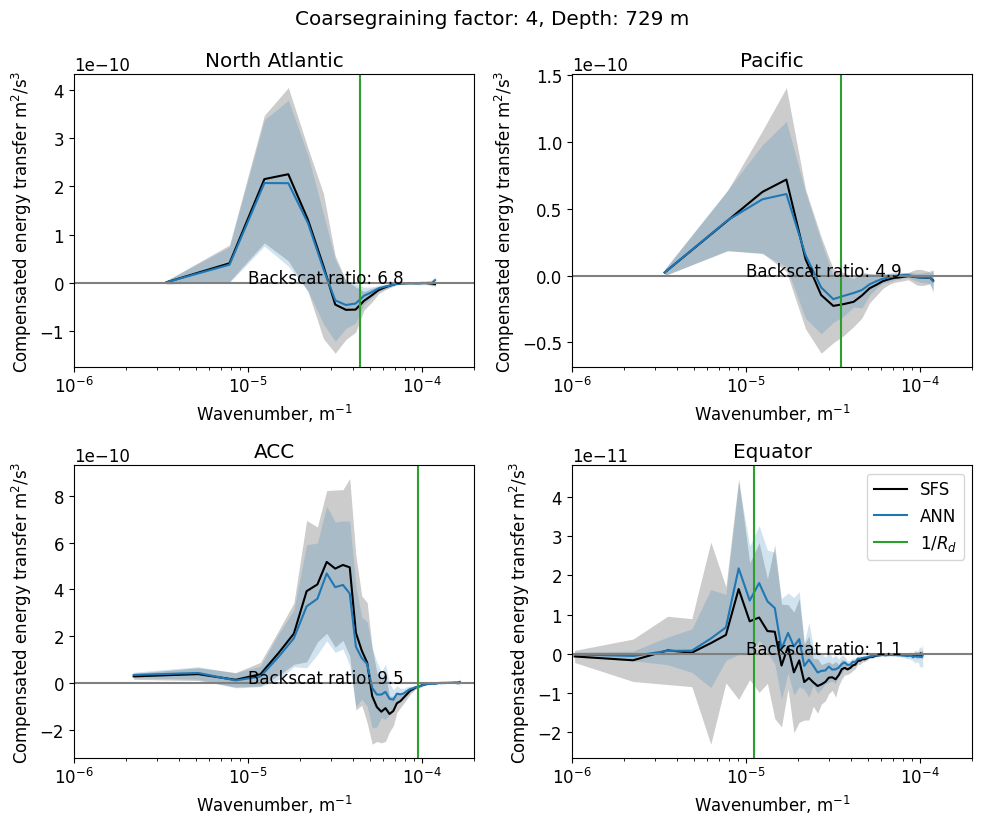

In [430]:
plot_transfer_4_regions()
plt.savefig('data-garbage/factor-4.pdf', bbox_inches='tight')

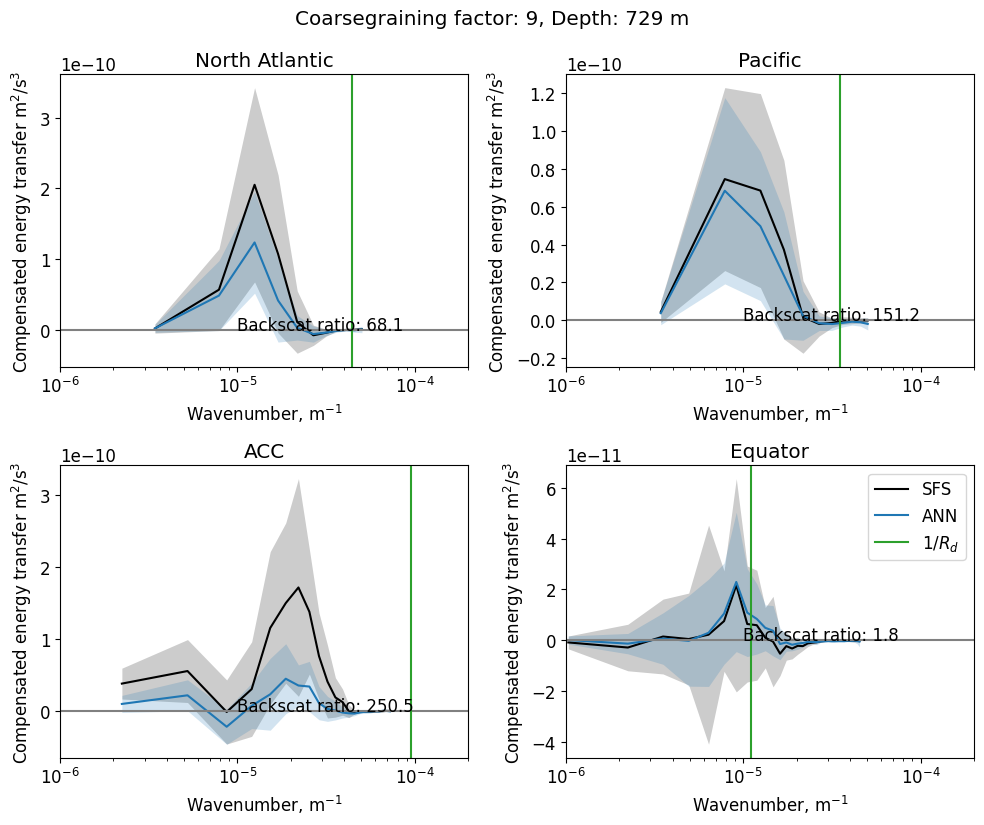

In [429]:
plot_transfer_4_regions(factor=9)
plt.savefig('data-garbage/factor-9.pdf', bbox_inches='tight')

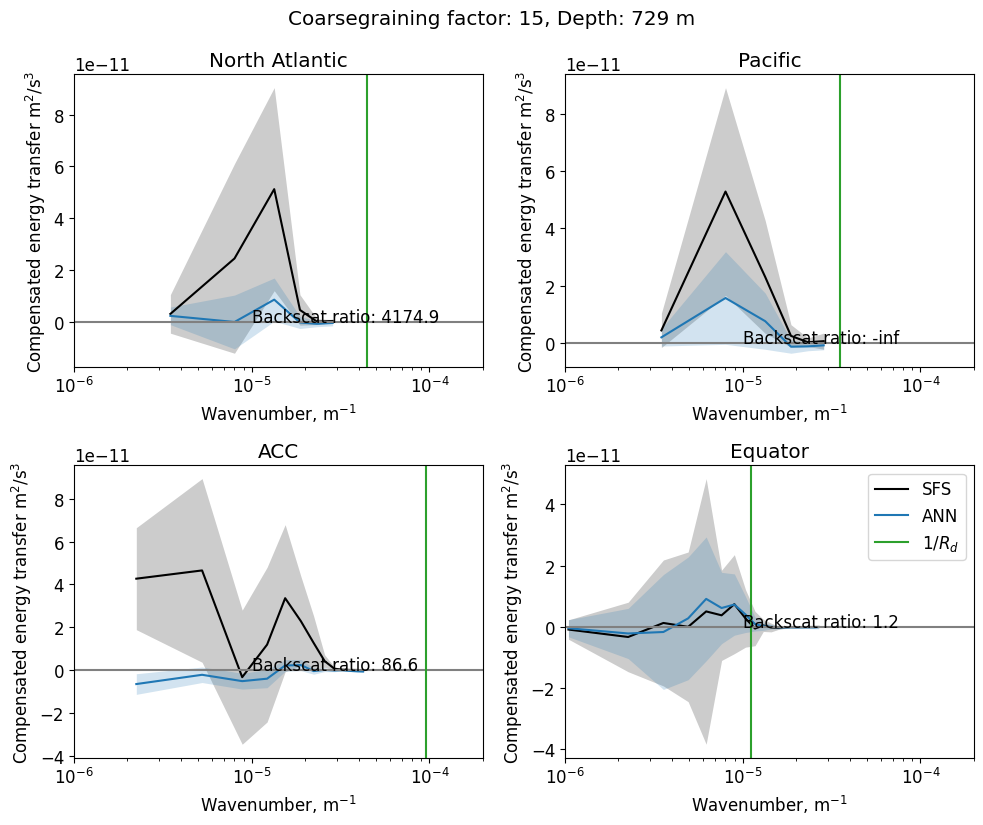

In [428]:
plot_transfer_4_regions(factor=15)
plt.savefig('data-garbage/factor-15.pdf', bbox_inches='tight')

# Spectral metric

In [2]:
def read_skill(exp='EXP0', factors=[4,9,12,15]):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/Gauss-FGR3/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = data['zl']
        ds[factor] = data
        
    return ds

In [20]:
import cmocean
def plot_metric(exp=None, region='NA',vmin=None,vmax=None, exp_target=None):

    if exp_target is None:
        vmin=-1; vmax=1
    else:
        vmin=-0.5; vmax=0.5
    
    def R2(test,target):
        target_mean = target.mean('time')
        test_mean = test.mean('time')
        error = target_mean - test_mean

        return 1 - (error**2).mean(f'freq_r_{region}') / (target_mean**2).mean(f'freq_r_{region}')

    R2_transfer = []
    R2_transfer_target=[]
    for factor in [4,9,12,15]:
        R2_transfer.append(R2(exp[factor][f'transfer_ZB_{region}'], exp[factor][f'transfer_{region}']))
        if exp_target is not None:
            R2_transfer_target.append(R2(exp_target[factor][f'transfer_ZB_{region}'], exp_target[factor][f'transfer_{region}']))

    R2_transfer = xr.concat(R2_transfer, dim='factor')
    R2_transfer['factor'] = [4,9,12,15]
    if exp_target is not None:
        R2_transfer_target = xr.concat(R2_transfer_target, dim='factor')
        R2_transfer_target['factor'] = [4,9,12,15]
    else:
        R2_transfer_target = 0 * R2_transfer

    (R2_transfer - R2_transfer_target).drop_vars(['zl', 'factor']).plot(x='factor', y='zl', cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, cbar_kwargs={'label':'$R^2$ in KE transfer'})
    plt.yticks(np.arange(10),[5, 55, 110, 180,330, 730,1500,2500,3500,4500]);
    plt.ylabel('Depth, m')
    plt.xticks(np.arange(4),[4,9,12,15])
    
    mean_val = float((R2_transfer-R2_transfer_target).mean())
    std_val = float((R2_transfer-R2_transfer_target).std())
    title = dict(NA='North Atlantic', Pacific='Pacific', ACC='ACC', Equator='Equator')
    plt.title(title[region]+'\n $R^2$[mean/std]=[%.3f,%.3f]' % (mean_val,std_val))
    
    plt.xlabel('Coarsegraining factor')
    plt.gca().invert_yaxis()

CPU times: user 165 ms, sys: 29.8 ms, total: 195 ms
Wall time: 913 ms


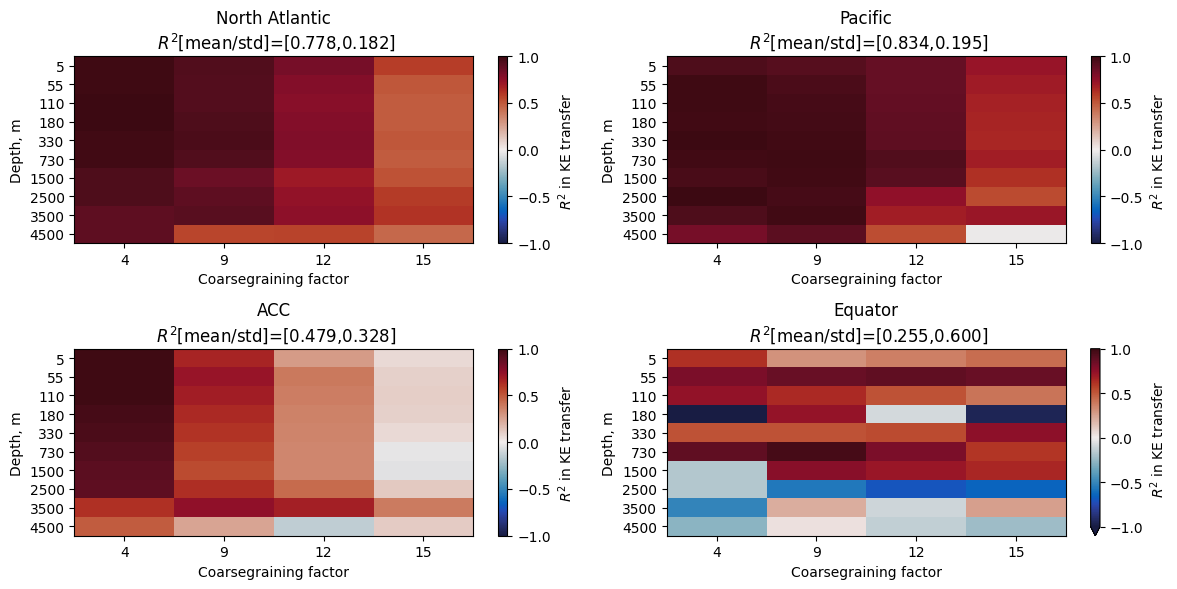

In [21]:
%time exp0 = read_skill('EXP0')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp0,'NA')
plt.subplot(2,2,2)
plot_metric(exp0,'Pacific')
plt.subplot(2,2,3)
plot_metric(exp0,'ACC')
plt.subplot(2,2,4)
plot_metric(exp0,'Equator')
plt.tight_layout()

CPU times: user 160 ms, sys: 27.9 ms, total: 188 ms
Wall time: 557 ms


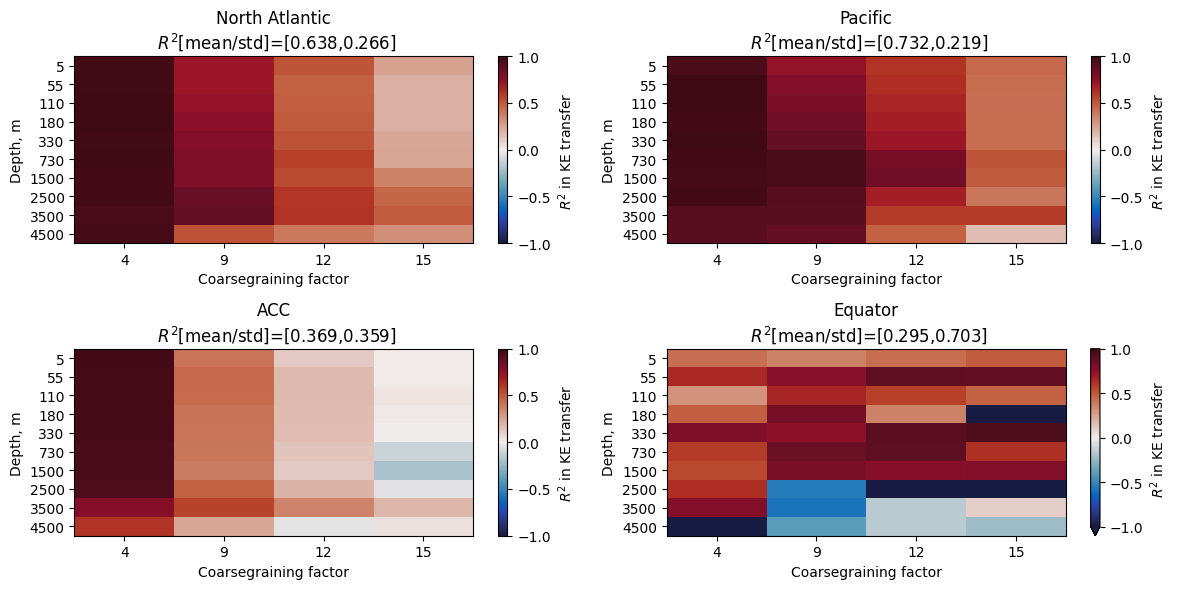

In [22]:
%time exp1 = read_skill('EXP1')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp1,'NA')
plt.subplot(2,2,2)
plot_metric(exp1,'Pacific')
plt.subplot(2,2,3)
plot_metric(exp1,'ACC')
plt.subplot(2,2,4)
plot_metric(exp1,'Equator')
plt.tight_layout()

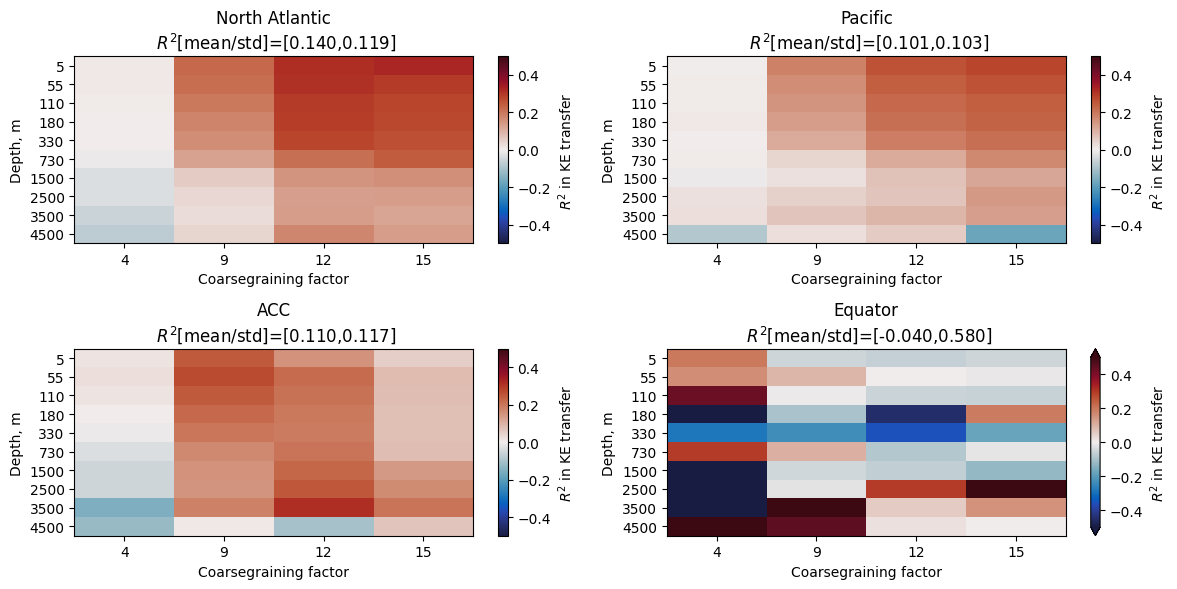

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp0,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp0,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp0,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp0,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 170 ms, sys: 35.3 ms, total: 205 ms
Wall time: 2.25 s


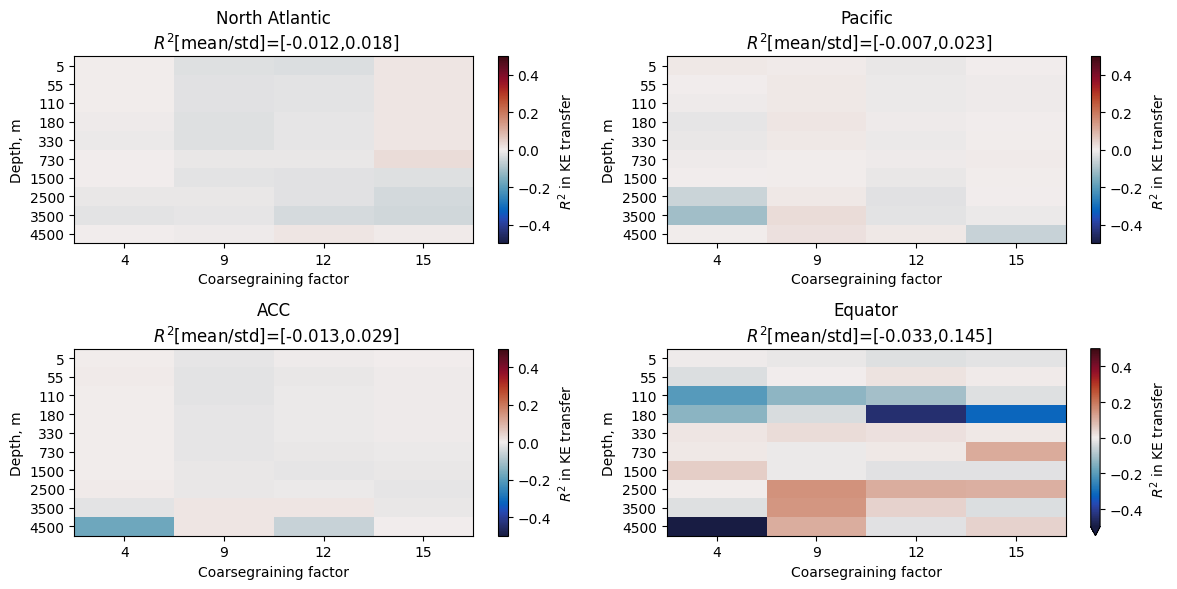

In [24]:
%time exp = read_skill('EXP1-sensitivity/repeat')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 171 ms, sys: 33.8 ms, total: 205 ms
Wall time: 3.83 s


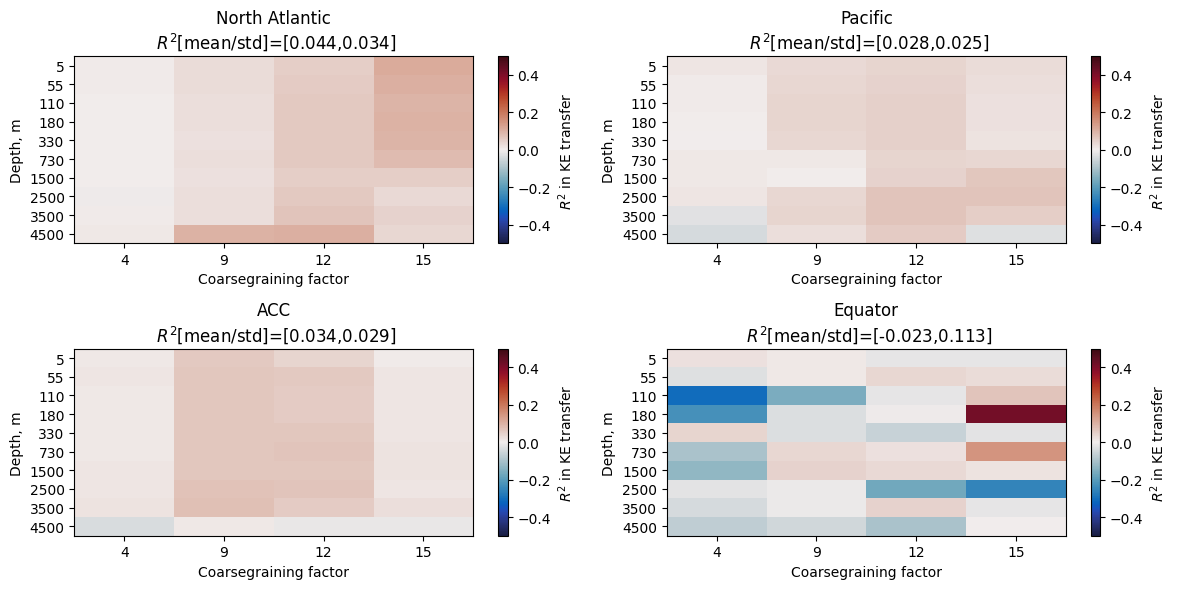

In [25]:
%time exp = read_skill('EXP1-sensitivity/time_iters')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 182 ms, sys: 28.6 ms, total: 210 ms
Wall time: 2.51 s


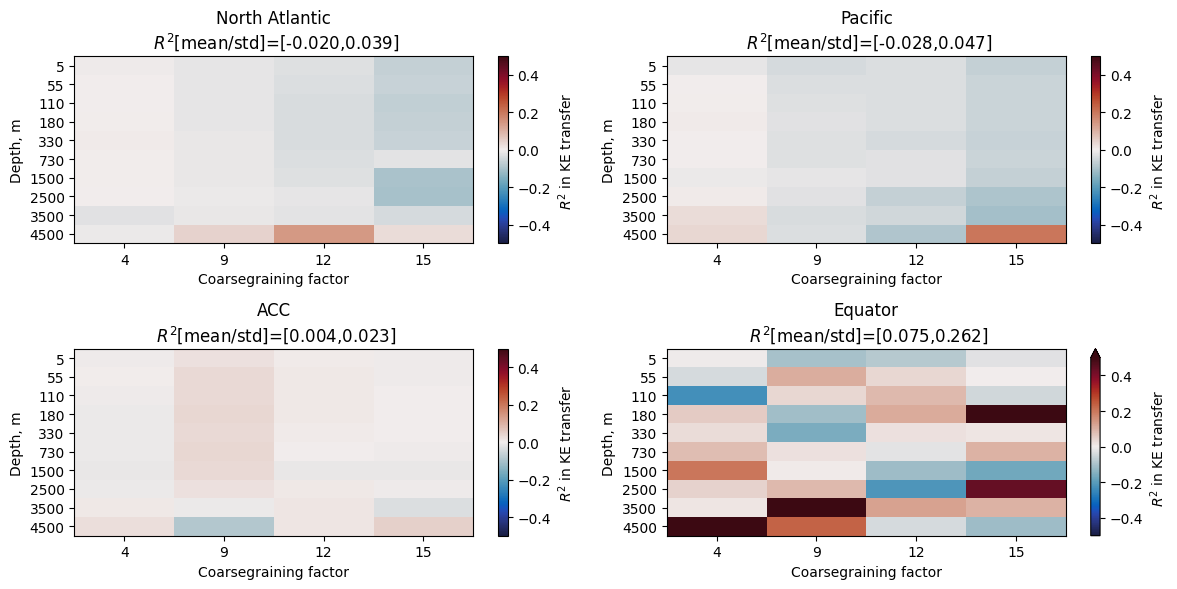

In [26]:
%time exp = read_skill('EXP1-sensitivity/collocated')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 169 ms, sys: 36.4 ms, total: 205 ms
Wall time: 1.8 s


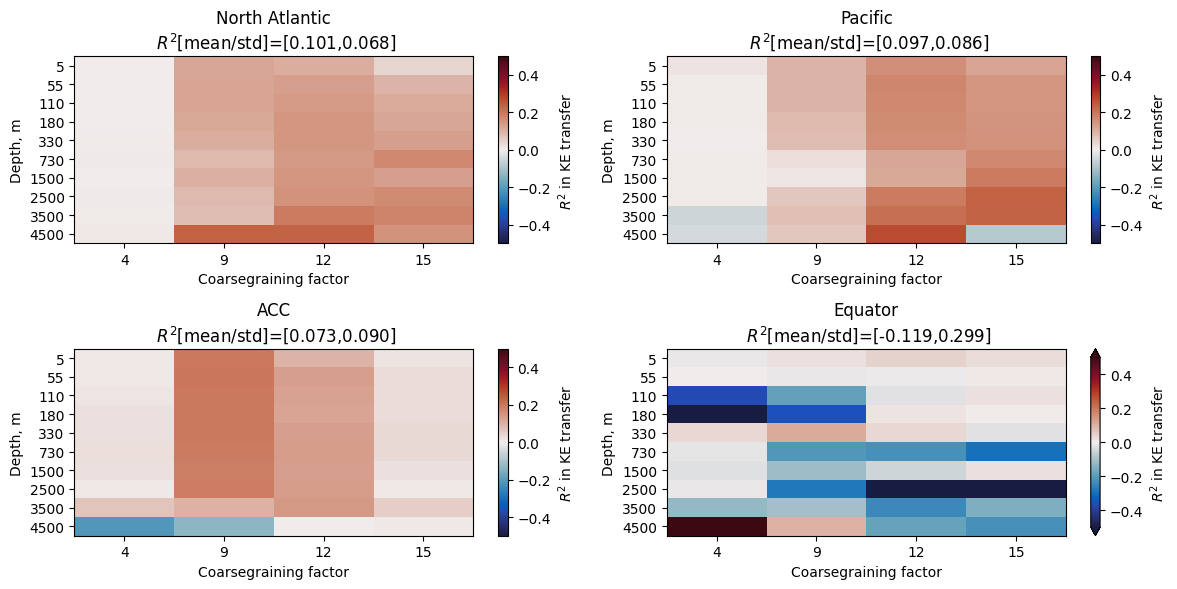

In [27]:
%time exp = read_skill('EXP1-sensitivity/5x5')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 176 ms, sys: 25.3 ms, total: 201 ms
Wall time: 1.95 s


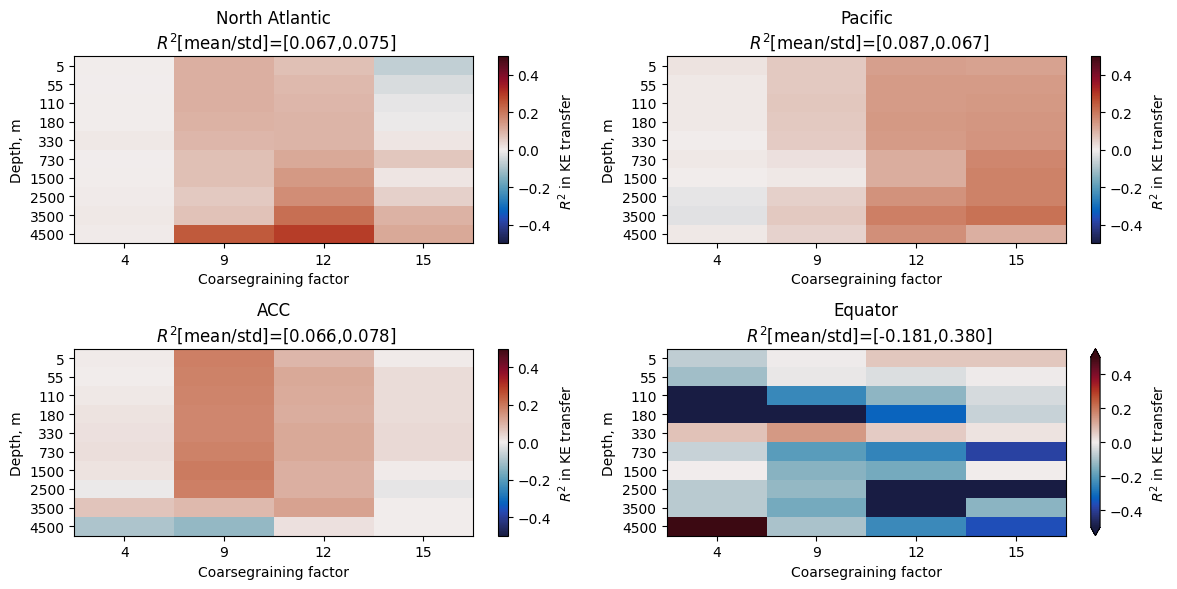

In [32]:
%time exp = read_skill('EXP1-sensitivity/9x9')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 177 ms, sys: 27.9 ms, total: 205 ms
Wall time: 2.21 s


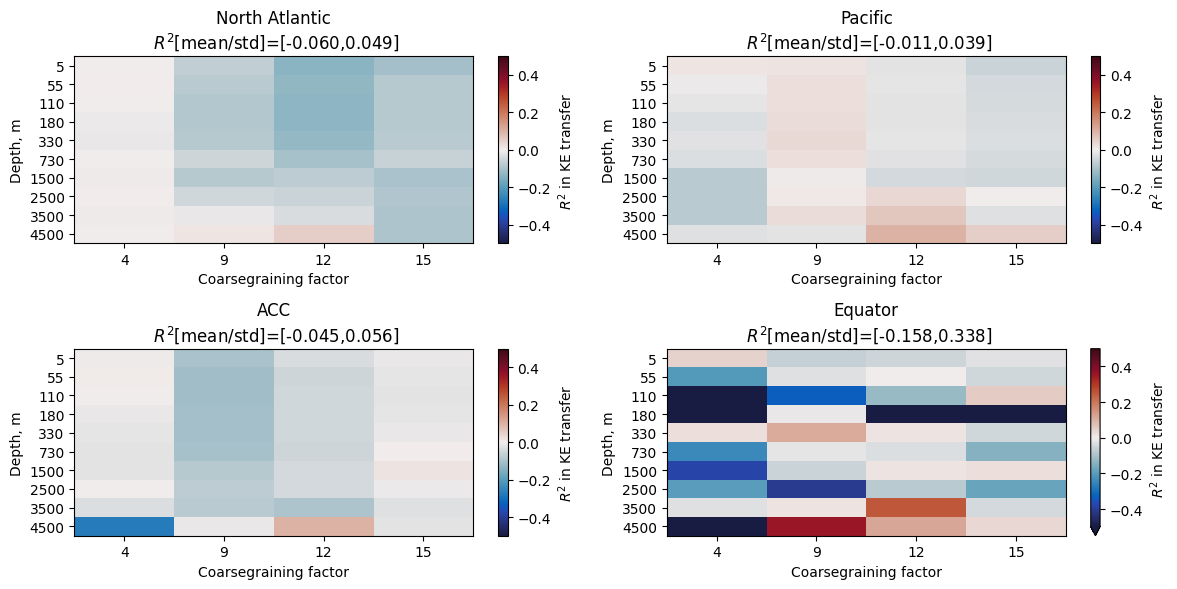

In [29]:
%time exp = read_skill('EXP1-sensitivity/strain')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 181 ms, sys: 38.3 ms, total: 219 ms
Wall time: 2.11 s


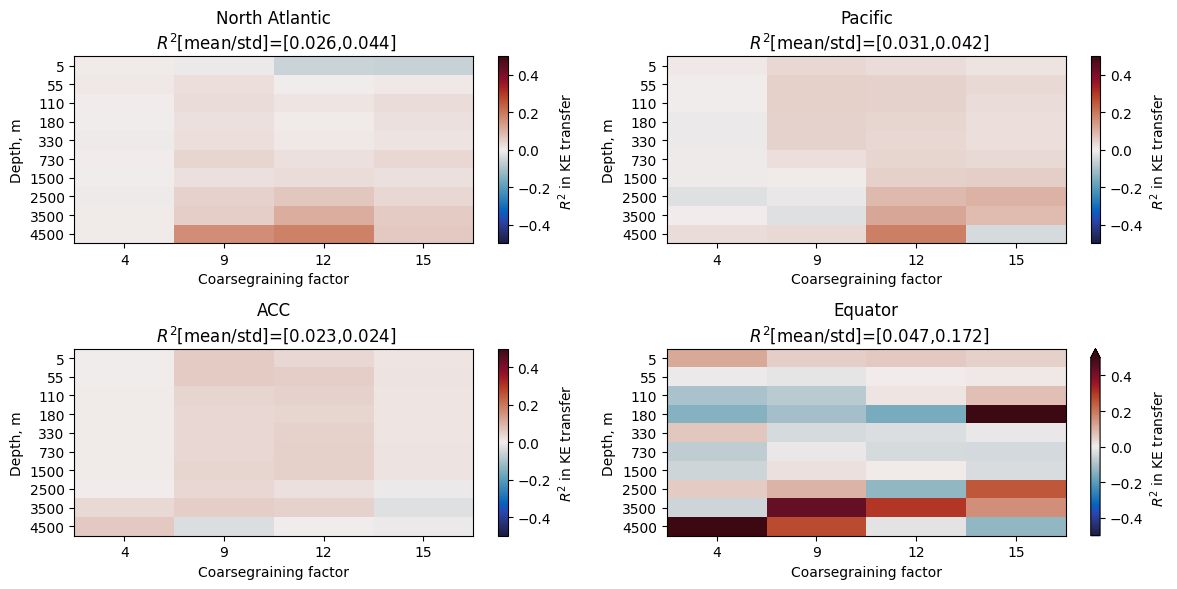

In [30]:
%time exp = read_skill('EXP1-sensitivity/div')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 176 ms, sys: 25.9 ms, total: 202 ms
Wall time: 1.82 s


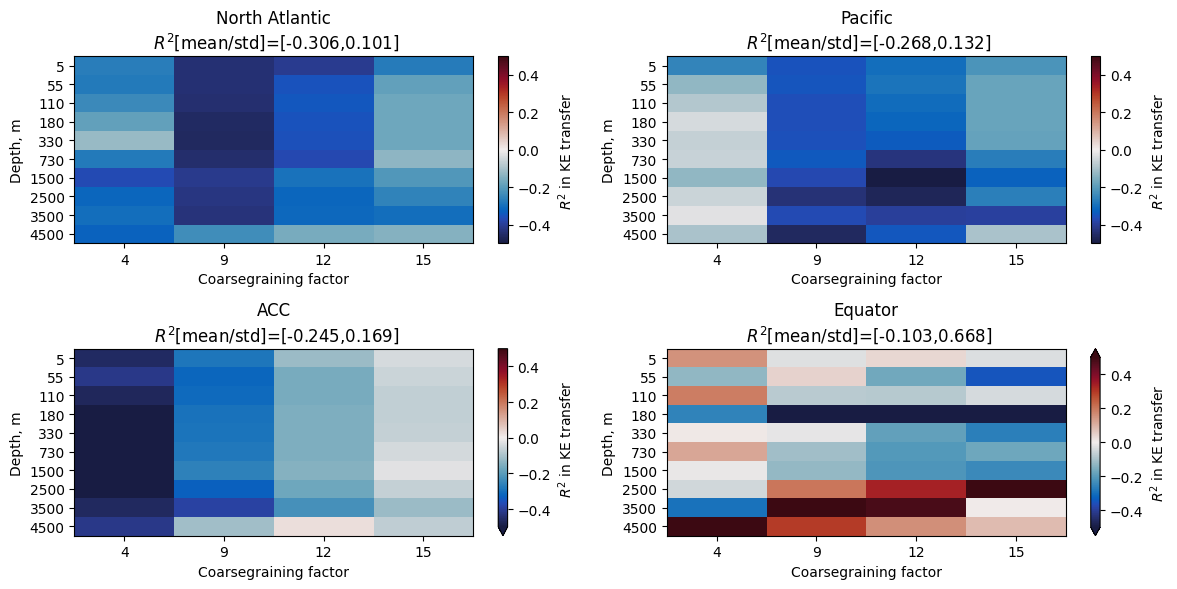

In [31]:
%time exp = read_skill('EXP1-sensitivity/1x1')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 181 ms, sys: 29 ms, total: 210 ms
Wall time: 2.93 s


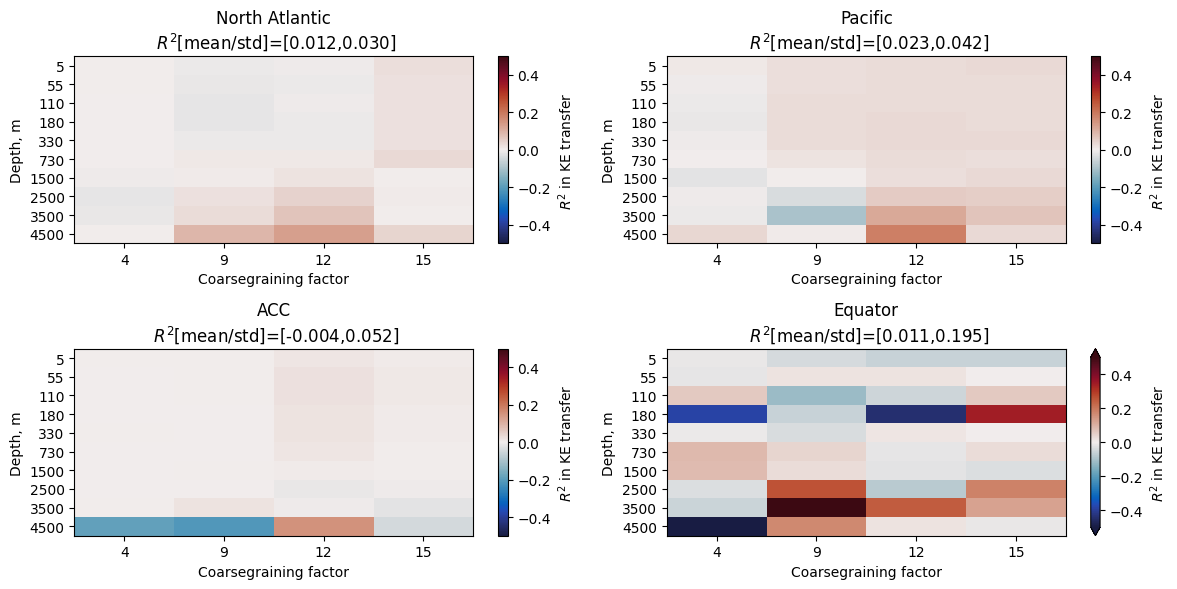

In [33]:
%time exp = read_skill('EXP1-sensitivity/nonsym')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 174 ms, sys: 28.1 ms, total: 202 ms
Wall time: 2 s


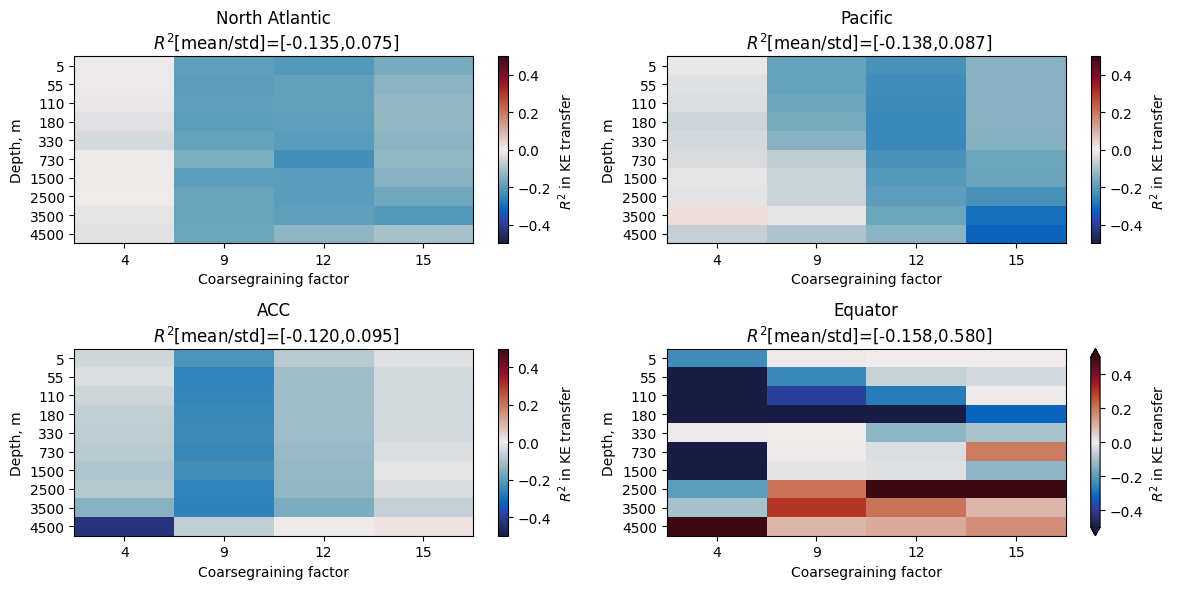

In [34]:
%time exp = read_skill('EXP1-sensitivity/layers-20')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 175 ms, sys: 36.3 ms, total: 212 ms
Wall time: 3.97 s


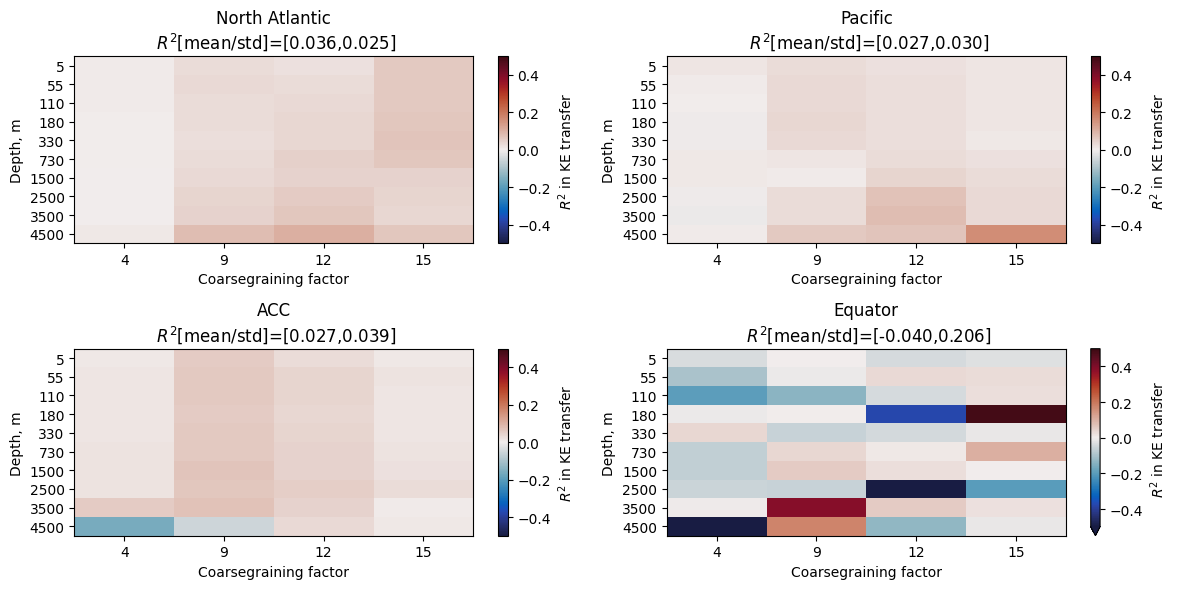

In [35]:
%time exp = read_skill('EXP1-sensitivity/layers-128-128')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp1)
plt.tight_layout()

CPU times: user 157 ms, sys: 28.7 ms, total: 186 ms
Wall time: 1.46 s


Text(0.5, 1.03, 'Hallberg 2013 vs Null')

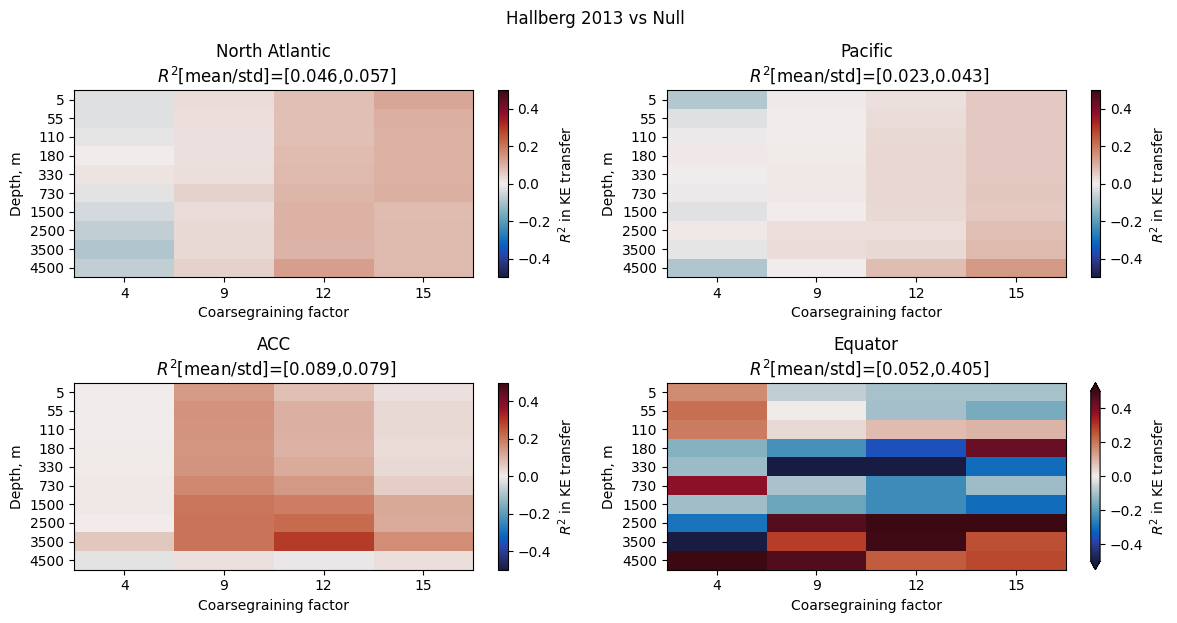

In [47]:
%time exp5 = read_skill('EXP5')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp5,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp5,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp5,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp5,'Equator',exp_target=exp1)
plt.tight_layout()
plt.suptitle('Hallberg 2013 vs Null', y=1.03)

CPU times: user 160 ms, sys: 37.1 ms, total: 197 ms
Wall time: 674 ms


Text(0.5, 1.03, 'Hallberg 2013 + rescaled depth vs Hallberg 2013')

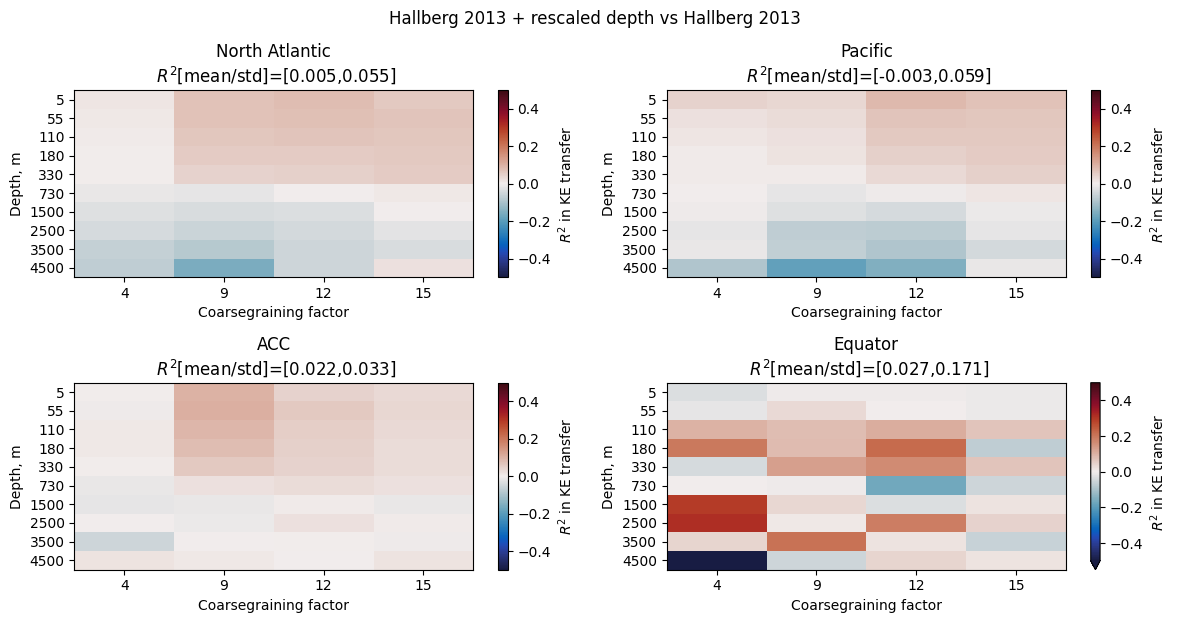

In [48]:
%time exp = read_skill('EXP6')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp5)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp5)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp5)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp5)
plt.tight_layout()
plt.suptitle('Hallberg 2013 + rescaled depth vs Hallberg 2013', y=1.03)

CPU times: user 157 ms, sys: 30.8 ms, total: 187 ms
Wall time: 818 ms


Text(0.5, 1.03, 'Hallberg 2013 + Held Larichev 1996 vs Hallberg 2013')

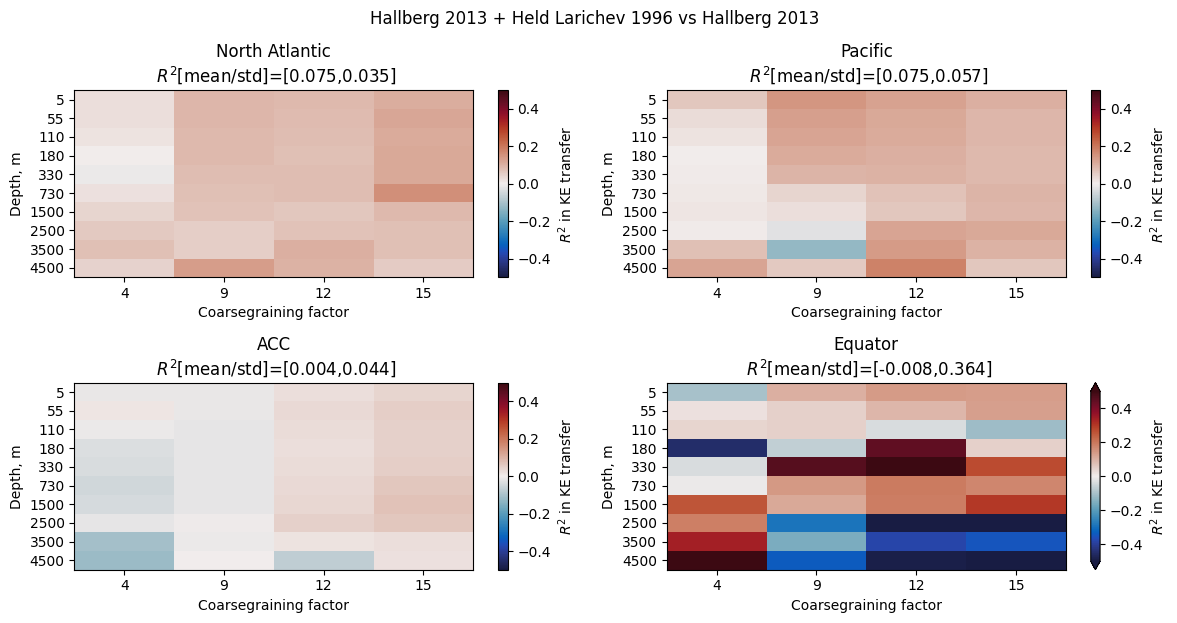

In [50]:
%time exp7 = read_skill('EXP7')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp7,'NA',exp_target=exp5)
plt.subplot(2,2,2)
plot_metric(exp7,'Pacific',exp_target=exp5)
plt.subplot(2,2,3)
plot_metric(exp7,'ACC',exp_target=exp5)
plt.subplot(2,2,4)
plot_metric(exp7,'Equator',exp_target=exp5)
plt.tight_layout()
plt.suptitle('Hallberg 2013 + Held Larichev 1996 vs Hallberg 2013', y=1.03)

CPU times: user 169 ms, sys: 30 ms, total: 199 ms
Wall time: 1.56 s


Text(0.5, 1.03, 'Hallberg 2013 + Held Larichev 1996 + Ri vs Hallberg 2013 + Held Larichev 1996')

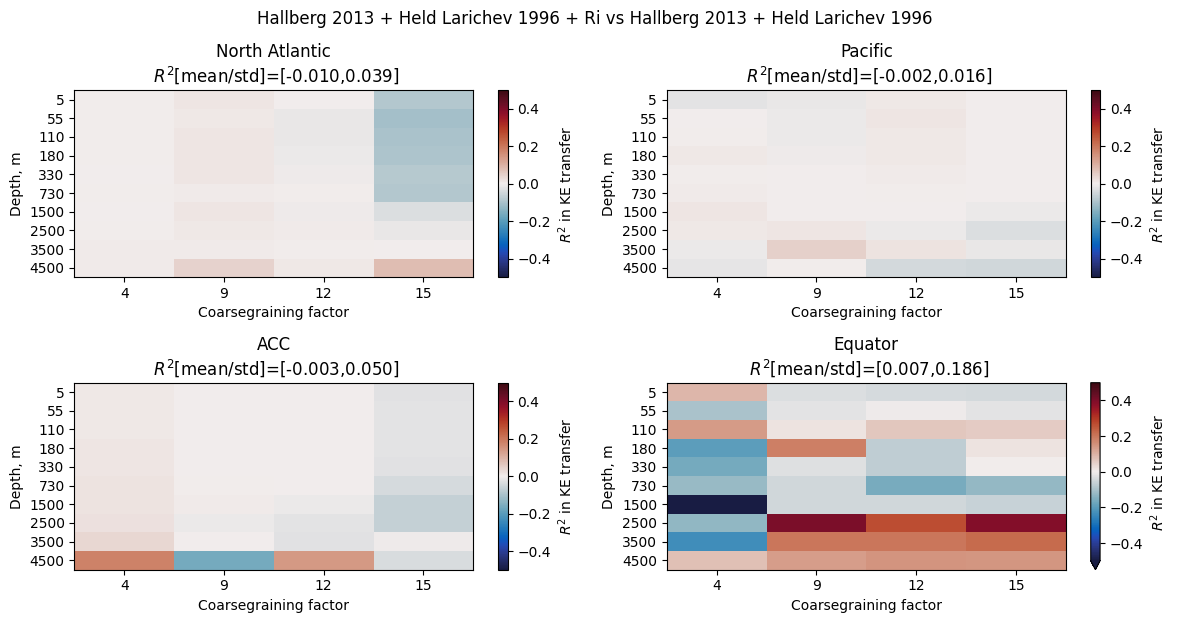

In [51]:
%time exp = read_skill('EXP8')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp7)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp7)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp7)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp7)
plt.tight_layout()
plt.suptitle('Hallberg 2013 + Held Larichev 1996 + Ri vs Hallberg 2013 + Held Larichev 1996', y=1.03)

CPU times: user 175 ms, sys: 35.4 ms, total: 210 ms
Wall time: 1.56 s


Text(0.5, 1.03, 'Hallberg 2013 + Held Larichev 1996 + rescaled depth vs Hallberg 2013 + Held Larichev 1996')

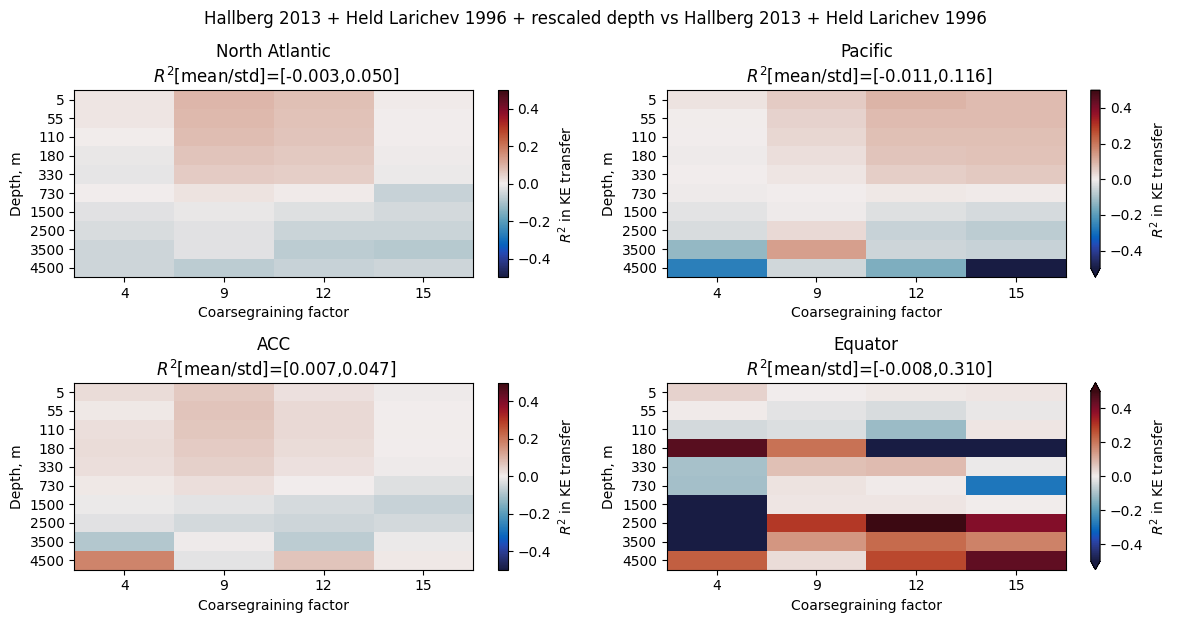

In [52]:
%time exp = read_skill('EXP9')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp7)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp7)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp7)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp7)
plt.tight_layout()

plt.suptitle('Hallberg 2013 + Held Larichev 1996 + rescaled depth vs Hallberg 2013 + Held Larichev 1996', y=1.03)

Text(0.5, 1.03, 'Hallberg 2013 + Held Larichev 1996 vs Hallberg 2013 + Held Larichev 1996 + Ri + rescaled depth')

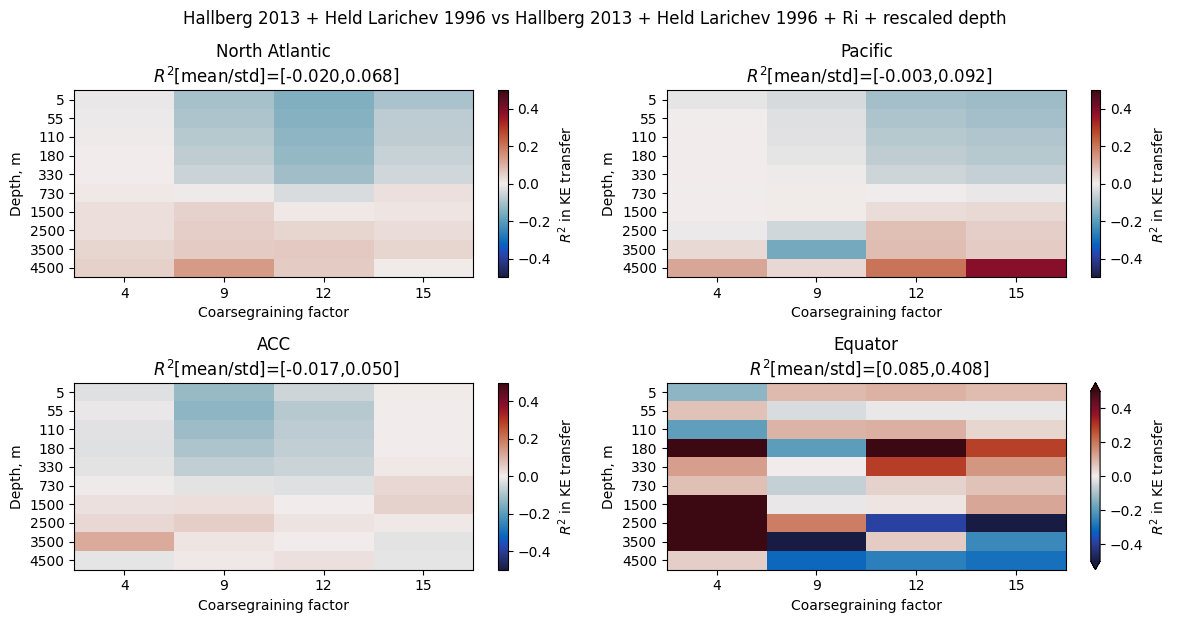

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp7,'NA',exp_target=exp0)
plt.subplot(2,2,2)
plot_metric(exp7,'Pacific',exp_target=exp0)
plt.subplot(2,2,3)
plot_metric(exp7,'ACC',exp_target=exp0)
plt.subplot(2,2,4)
plot_metric(exp7,'Equator',exp_target=exp0)
plt.tight_layout()

plt.suptitle('Hallberg 2013 + Held Larichev 1996 vs Hallberg 2013 + Held Larichev 1996 + Ri + rescaled depth', y=1.03)

Text(0.5, 1.03, 'Hallberg 2013 + Held Larichev 1996 vs Null')

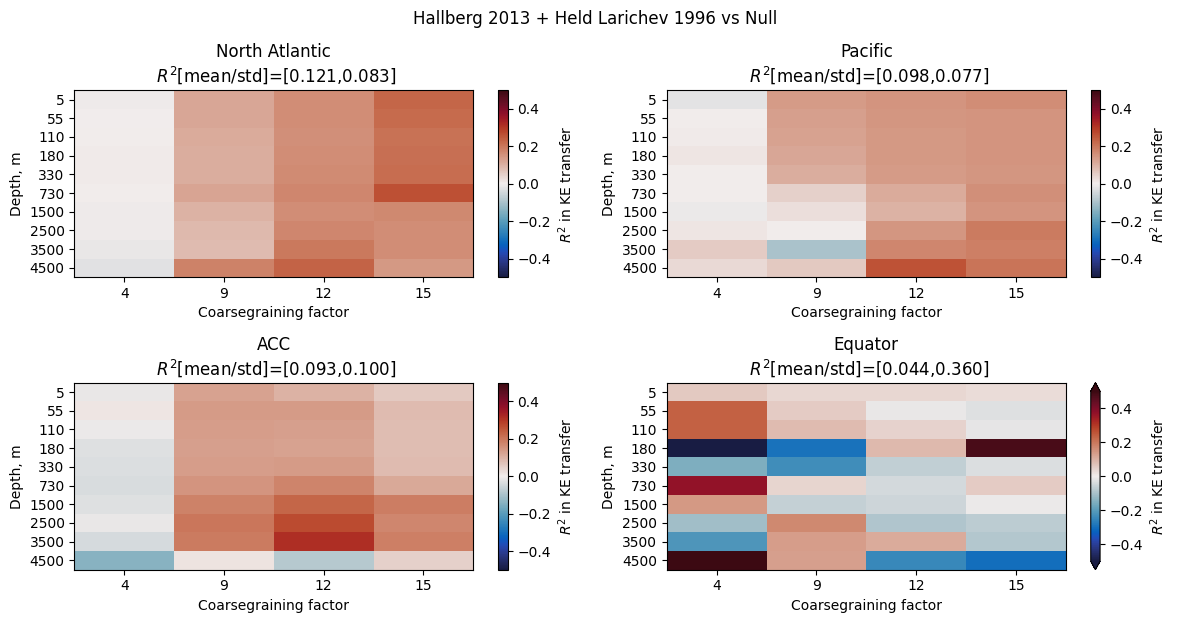

In [54]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp7,'NA',exp_target=exp1)
plt.subplot(2,2,2)
plot_metric(exp7,'Pacific',exp_target=exp1)
plt.subplot(2,2,3)
plot_metric(exp7,'ACC',exp_target=exp1)
plt.subplot(2,2,4)
plot_metric(exp7,'Equator',exp_target=exp1)
plt.tight_layout()

plt.suptitle('Hallberg 2013 + Held Larichev 1996 vs Null', y=1.03)

CPU times: user 161 ms, sys: 28.8 ms, total: 190 ms
Wall time: 461 ms


Text(0.5, 1.03, 'Increased stencil vs Hallberg 2013 + Held Larichev 1996')

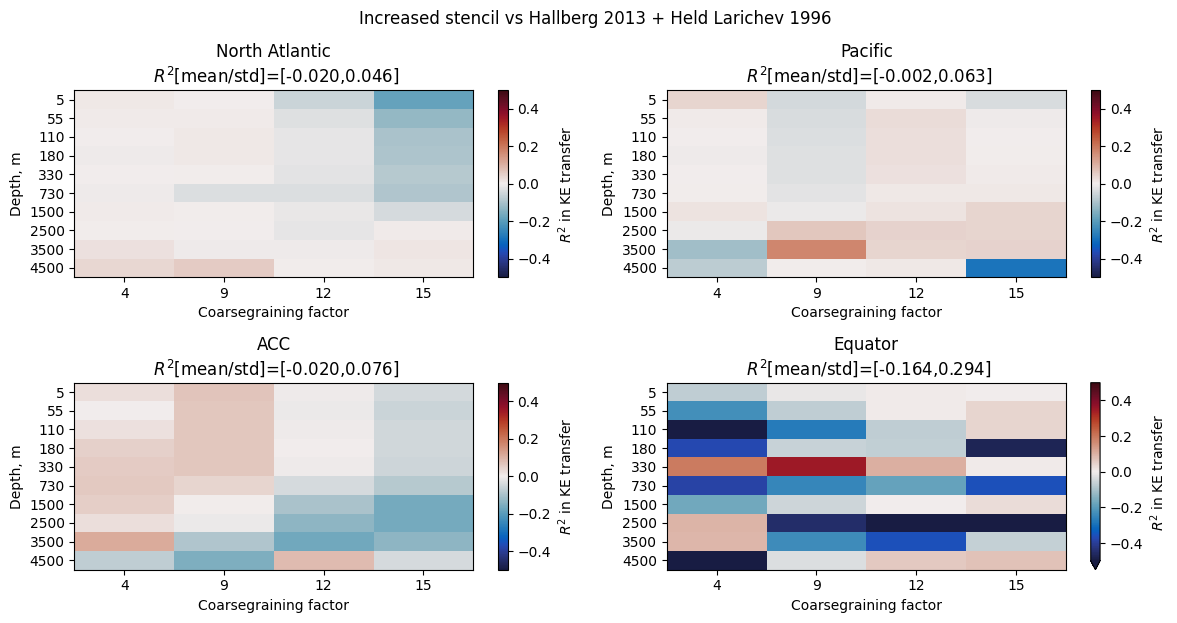

In [57]:
%time exp = read_skill('EXP1-sensitivity/5x5')
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_metric(exp,'NA',exp_target=exp7)
plt.subplot(2,2,2)
plot_metric(exp,'Pacific',exp_target=exp7)
plt.subplot(2,2,3)
plot_metric(exp,'ACC',exp_target=exp7)
plt.subplot(2,2,4)
plot_metric(exp,'Equator',exp_target=exp7)
plt.tight_layout()

plt.suptitle('Increased stencil vs Hallberg 2013 + Held Larichev 1996', y=1.03)

# Summary
* Hallberg 2013 and Held Larichev 1996 parameters are the most important for improving the KE transfer. The impact of rescaled depth and Ri can be considered as insignificant. 
* The effect is comparable and a bit better than increasing stencil to 5x5. 